In [14]:
import tempfile

from monai.visualize.utils import matshow3d, blend_images
from monai.data import CacheDataset, ThreadDataLoader
from monai.transforms import (
    Compose,
    LoadImaged,
    ScaleIntensityRanged,
    Orientationd,
    Spacingd,
    CropForegroundd,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    EnsureTyped,
    BorderPad,
    SaveImaged,
    RandRotated,
    Rotated,
    Flipd
)

from monai.data import  decollate_batch

import matplotlib.pyplot as plt
from basic_unet import BasicUNet
from monai.inferers import sliding_window_inference

from monai.losses import DiceCELoss, FocalLoss

from monai.metrics import DiceMetric, ROCAUCMetric,LossMetric

from torch.optim.lr_scheduler import ReduceLROnPlateau

from monai.transforms import AsDiscrete

from tqdm import tqdm

from nodule_transforms.LoadArterysMaskd import LoadArterysMaskd
from nodule_transforms.AddCustomerMetadatad import AddCustomerMetadatad
from nodule_transforms.CropToNoduled import CropToNoduled
from nodule_transforms.EncodeClassIntoMask import EncodeClassIntoMask

import os
import torch
import numpy as np
import pandas as pd


from data_tools.datatools import load_cancer_nodules_datalist, split_data, balance_and_split_data


# Save random seed
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

directory = './monai_data'
if not os.path.exists(directory):
    os.makedirs(directory)
    
root_dir = tempfile.mkdtemp() if directory is None else directory
cache_dir = './training_cache'

CANCER_NODULES_DATASET_DIR = '/media/vlermakov/data/UCSDNodules/Metastatic/'
#PRE_PROCESSED_DIRECTORY = '/home/vlermakov/Development/Nodules/Nodule-Detection-LUNA2016/processed_data_full_range/'
PRE_PROCESSED_SUBFOLDER = '/home/vlermakov/Development/Nodules/Nodule-Detection-LUNA2016/processed_data_full_range_075mm_fixed/'
#PRE_PROCESSED_SUBFOLDER = './processed_data_unetr_range/'
#PRE_PROCESSED_SUBFOLDER = './processed_data_full_range_1mm/'


dataset = pd.read_csv(os.path.join(CANCER_NODULES_DATASET_DIR, "dataset.csv"), dtype={'MRN': str})

# Ignore class = 1
#dataset = dataset[dataset.label != 1]

# All class 2 set to class 1
dataset.loc[dataset.label == 2, 'label'] = 1

datalist = load_cancer_nodules_datalist(CANCER_NODULES_DATASET_DIR, PRE_PROCESSED_SUBFOLDER)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processed_scans = []
unprocessed_scans = []

n_processed = 0
for p in datalist:
    if p['pre_processed']:
        n_processed += 1 
        processed_scans.append(p)
    else:
        unprocessed_scans.append(p)




Processing MRN 211 Phonetic_ID Fesaho
Processing MRN 210 Phonetic_ID Quabemo
Processing MRN 209 Phonetic_ID Quekelurn
Processing MRN 208 Phonetic_ID Jufueklip
Processing MRN 207 Phonetic_ID Moyabdof
Processing MRN 206 Phonetic_ID Tudipi
Processing MRN 205 Phonetic_ID Nousisig
Processing MRN 204 Phonetic_ID Budueyi
Processing MRN 203 Phonetic_ID Jenuda
Processing MRN 202 Phonetic_ID Cretaha
Processing MRN 201 Phonetic_ID Pejaru
Processing MRN 200 Phonetic_ID Barethue
Processing MRN 199 Phonetic_ID Miekefre
Processing MRN 198 Phonetic_ID Labfaljon
Processing MRN 196 Phonetic_ID Togepel
Processing MRN 195 Phonetic_ID Diclama
Processing MRN 194 Phonetic_ID Worowof
No json file found for patch_id_stub 603d4040eebdcd0a54995523-4a146fafa3461460
Processing MRN 193 Phonetic_ID Loomako
Processing MRN 192 Phonetic_ID Puguxiep
Processing MRN 191 Phonetic_ID Alnpatik
Processing MRN 190 Phonetic_ID Beelelu
Processing MRN 189 Phonetic_ID Omlolit
Processing MRN 189 Phonetic_ID Pihoko
Processing MRN 18

Processing MRN 17 Phonetic_ID Swofeku
Processing MRN 16 Phonetic_ID Ridine
Processing MRN 15 Phonetic_ID Mohuteg
Patch ID nan is not a string
Processing MRN 14 Phonetic_ID Rakajid
Processing MRN 13 Phonetic_ID Jaquesif
Processing MRN 12 Phonetic_ID Bekubo
Processing MRN 11 Phonetic_ID Agunit
Processing MRN 10 Phonetic_ID Nidogek
Processing MRN 9 Phonetic_ID Lorutink
Processing MRN 9 Phonetic_ID Dihudi
Processing MRN 8 Phonetic_ID Socaba
Processing MRN 7 Phonetic_ID Ukebjiem
Processing MRN 6 Phonetic_ID Olcisof
Processing MRN 6 Phonetic_ID Jebeemu
Processing MRN 5 Phonetic_ID Jasnuflo
Processing MRN 4 Phonetic_ID Gunifa
Processing MRN 3 Phonetic_ID Tusliblu
Processing MRN 2 Phonetic_ID Sopoopra
Processing MRN 1 Phonetic_ID Minfirag


In [50]:

train_transforms = Compose([
        LoadImaged(keys=["image"], ensure_channel_first=True, image_only=False),
        
        Flipd(keys=["image"]),
        
    ]
)


train_data_list = processed_scans[:10]

train_data_list = train_data_list

train_ds = CacheDataset(
    data=train_data_list,
    transform=train_transforms,
    cache_num=len(train_data_list),
    cache_rate=1.0,
    num_workers=8,
)

train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)



Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 94.71it/s]


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 89.91it/s]


image shape: torch.Size([1, 96, 96, 96]), mask shape: torch.Size([1, 96, 96, 96])


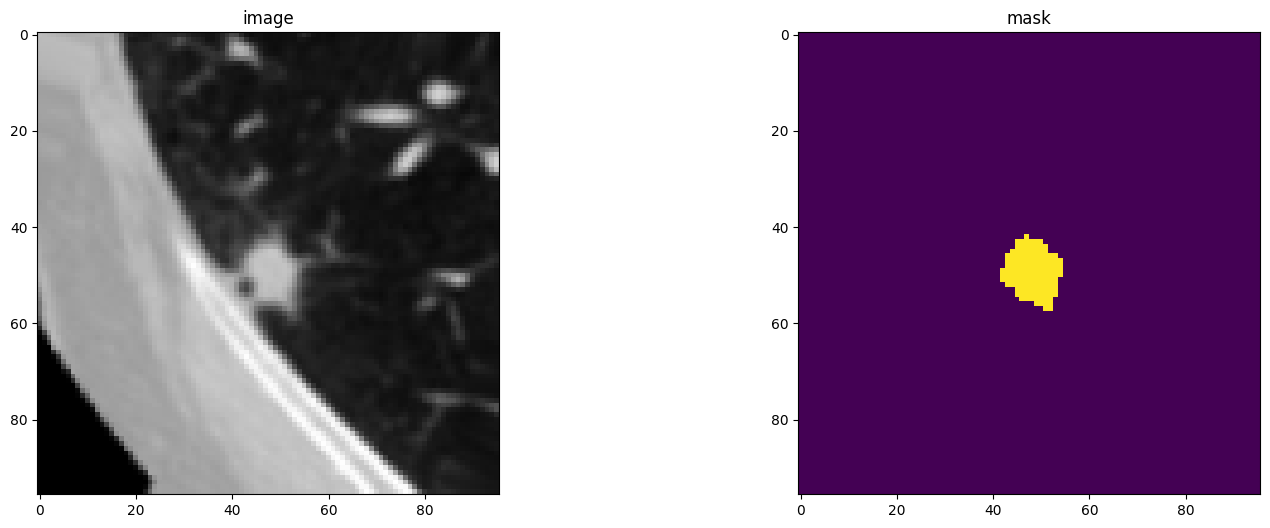

image shape: torch.Size([1, 96, 96, 96]), mask shape: torch.Size([1, 96, 96, 96])


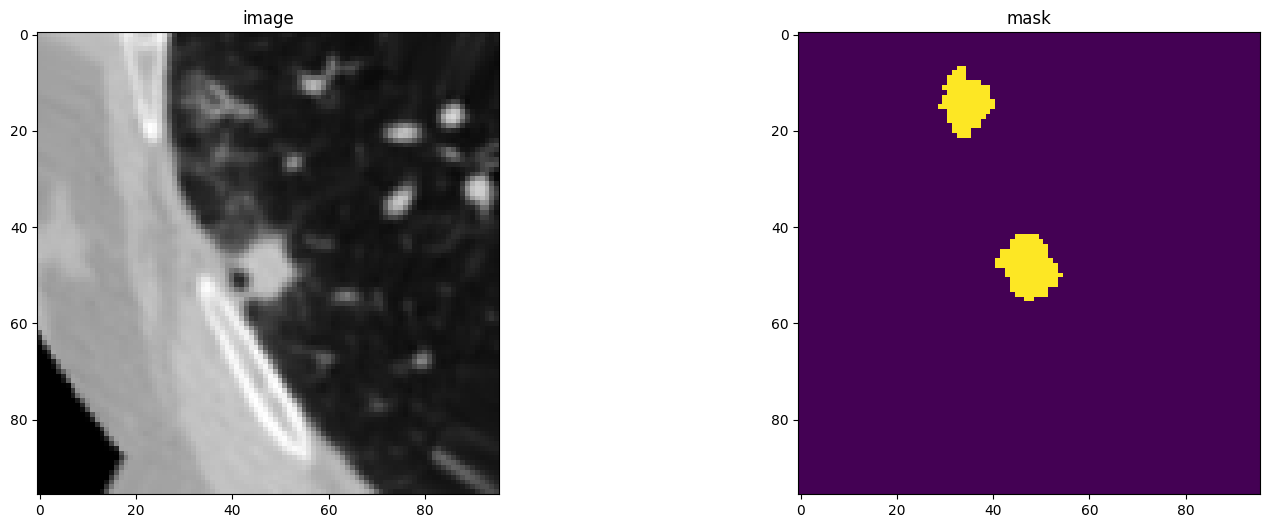

image shape: torch.Size([1, 96, 96, 96]), mask shape: torch.Size([1, 96, 96, 96])


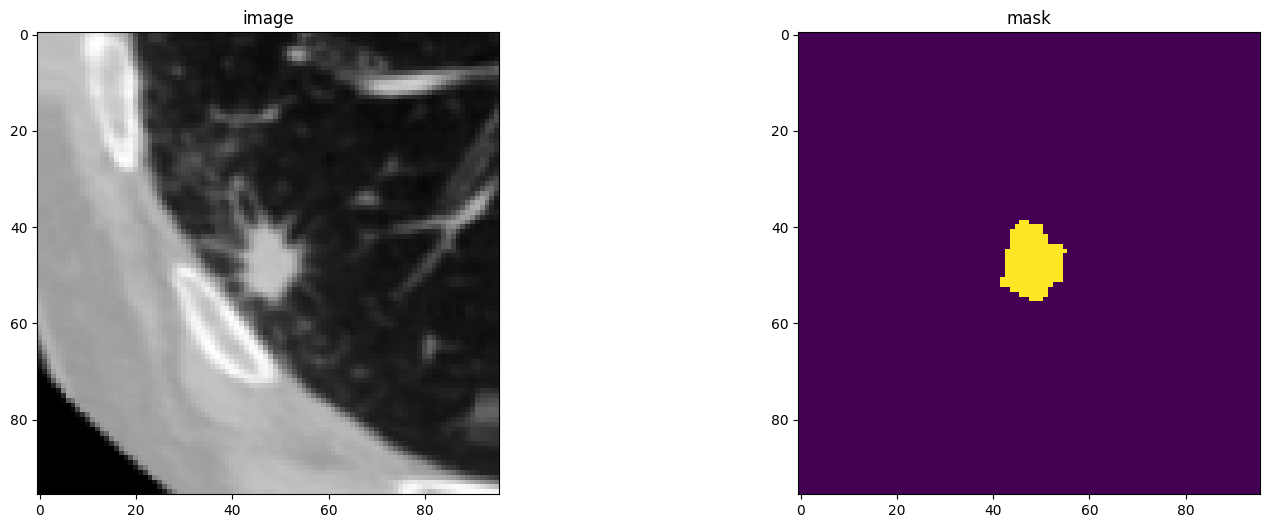

image shape: torch.Size([1, 96, 96, 96]), mask shape: torch.Size([1, 96, 96, 96])


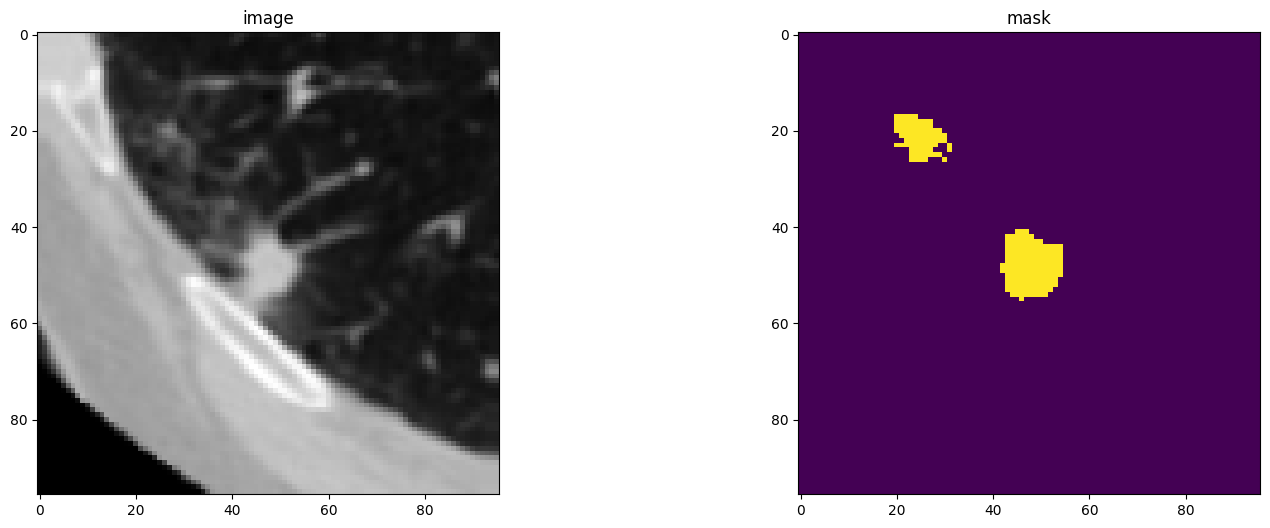

In [61]:
train_transforms = Compose([
        LoadImaged(
            keys=["image"], 
            ensure_channel_first=True, 
            image_only=False
        ),
        LoadImaged(keys=["mask"], ensure_channel_first=True, image_only=False),
#         Flipd(
#             keys=["image"],
#             spatial_axis=[0],
#         ),
        #Rotated(keys=["image"], angle=0.2, mode=["bilinear"]),
        RandRotated(keys=["image","mask"],
                    range_y=np.pi/6,
                    range_x=np.pi/6,
                    range_z=np.pi/6,
                    prob=1, mode=["bilinear","nearest"]),
    
        
    ]
)


train_data_list = processed_scans[:10]

train_data_list = train_data_list

train_ds = CacheDataset(
    data=train_data_list,
    transform=train_transforms,
    cache_num=len(train_data_list),
    cache_rate=1.0,
    num_workers=8,
)

train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)



case_num = 2
for i in range(4):
    testcase = train_ds[case_num]
    #img_name = os.path.split(train_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = testcase["image"].cpu()
    mask = testcase["mask"].cpu()
    img_shape = img.shape
    mask_shape = mask.shape
    print(f"image shape: {img_shape}, mask shape: {mask_shape}")
    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(img[0, :, :, img_shape[-1]//2].detach().cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("mask")
    plt.imshow(mask[0, :, :, img_shape[-1]//2].detach().cpu())
    plt.show()


# blended_image = blend_images(img, mask, alpha=0.5, cmap="hsv")
# # Generate two plot windows with two figures
# fig1 = plt.figure()

# matshow3d(blended_image, channel_dim = 0, fig = fig1, frame_dim=-1)
# plt.show()